<a href="https://colab.research.google.com/github/akatukam/Data-Exploration/blob/main/data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Importing the dataframes**

In [ ]:
import pandas as pd
import numpy as np
import scipy as sp
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

worksheet = gc.open('Copy of Dataset Generation (Max) (Responses)').sheet1
worksheet2 = gc.open('Copy of Dataset Generation (Fardina) (Responses)').sheet1
rows = worksheet.get_all_values()
rows2 = worksheet2.get_all_values()

df1 = pd.DataFrame(rows[1:], columns=rows[0])
df2 = pd.DataFrame(rows2[1:], columns=rows2[0])

## **Cleaning & combining the data**

---



In [ ]:
# fixing the prompt in Fardina's survey to allow the merging to happen properly
df2 = df2.rename(columns={'My wife has decided that since she can’t drink because she is pregnant that I can’t either. I planned to take my annual leave from work to take us (and pay for) a trip abroad. I asked my wife would the drinking rule still be in effect and she said of course. I’ve now decided I won’t be paying for us to take this trip. Am I jerk?':
                          'My wife has decided that since she can’t drink because she is pregnant that I can’t either. I planned to take my annual leave from work to take us (and pay for) a trip abroad. I asked my wife would the drinking rule still be in effect and she said of course. I’ve now decided I won’t be paying for us to take this trip. Am I a jerk?'})

# merging the dataframes
df = pd.concat([df1, df2], axis = 0)

# remove the column with the compassion question
del df['Would you describe yourself as compassionate?']

# removing rows with more than three missing entries
remove_rows = []
for index, row in df.iterrows():
    counter = sum(cell == '' for cell in row)
    if counter > 3:
        remove_rows.append(index)

df = df.drop(remove_rows)

# replacing missing values with the mode
for column in df.columns:
    mode_val = df[column].mode()[0]
    df.loc[df[column].isna(), column] = mode_val

# removing gender where they would prefer not to say
df = df[df['What bests represents your gender?'] != 'Prefer not to say']

# replacing "famale" with "female"
df['What bests represents your gender?'] = df['What bests represents your gender?'].replace('Famale', 'Female')

## **Question 1: Does being liberal cause a statistically significant difference in the level to which an individual considers a person a jerk?**

In [ ]:
# defining functions to help sum how many of each asessment there was
# (assessment meaning stringly a jerk, mildly, etc.)
def not_jerk_count(row):
    return row.str.count('Not a jerk').sum()
def strong_jerk_count(row):
    return row.str.count('Strongly a jerk').sum()
def mild_jerk_count(row):
    return row.str.count('Mildly a jerk').sum()

# creating columns to total up the number of each assessment
df['Sum of Not a Jerk'] = df.apply(not_jerk_count, axis=1)
df['Sum of Strongly a Jerk'] = df.apply(strong_jerk_count, axis=1)
df['Sum of Mildly a Jerk'] = df.apply(mild_jerk_count, axis=1)
df['YoursMod'] = df['You could describe yourself as...'].str.replace(r'Strongly |Mildly ', '', regex=True)

# creating the contingency table
liberal_jerk = pd.DataFrame(0, index=["strongly a jerk", "mildly a jerk", "not a jerk"], columns=["liberal", "not liberal"])
for index, row in df.iterrows():
    if row['YoursMod'] == "liberal":
        liberal_jerk.loc['strongly a jerk', 'liberal'] += row['Sum of Strongly a Jerk']
        liberal_jerk.loc['mildly a jerk', 'liberal'] += row['Sum of Mildly a Jerk']
        liberal_jerk.loc['not a jerk', 'liberal'] += row['Sum of Not a Jerk']
    else:
        liberal_jerk.loc['strongly a jerk', 'not liberal'] += row['Sum of Strongly a Jerk']
        liberal_jerk.loc['mildly a jerk', 'not liberal'] += row['Sum of Mildly a Jerk']
        liberal_jerk.loc['not a jerk', 'not liberal'] += row['Sum of Not a Jerk']

# running a chi squared test to see if there is a significant association between whether youre a liberal and the level to which you consider someone a jerk
# Null hypothesis: Being liberal and the level to which you consider people jerks are independent variables
# Alternate hypothesis: There's a significant association between being liberal and the level to which you consider people jerks
chi2, p, dof, expected = sp.stats.chi2_contingency(liberal_jerk)
print("Contingency Table:", liberal_jerk)
# there is no statistically significant association between being liberal and the level to which you consider people jerks
print("P-value:", p)

df = df.drop(['Sum of Not a Jerk', 'Sum of Strongly a Jerk', 'Sum of Mildly a Jerk', 'YoursMod'], axis=1)

Contingency Table:                  liberal  not liberal
strongly a jerk      413          296
mildly a jerk        645          376
not a jerk           755          485
P-value: 0.11734605544881194


## **Question 2: Does being male cause a statistically significant difference in the level to which an individual considers a person in an interaction with a woman a jerk?**

Contingency Table:                  man  not a man
strongly a jerk  413        190
mildly a jerk    589        193
not a jerk       543        195
P-value: 0.015136636993645433
P-value of one-tailed t-test: 0.9544699474229043


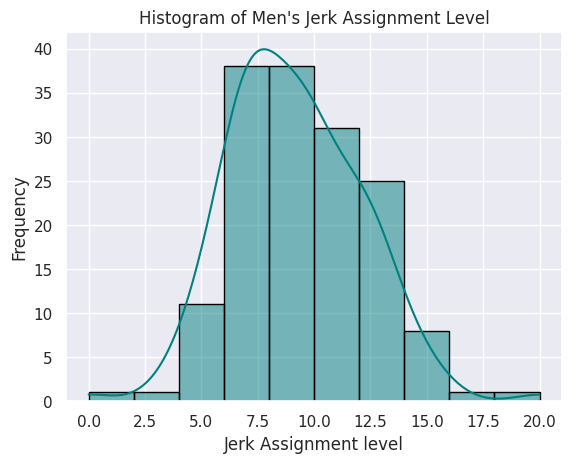

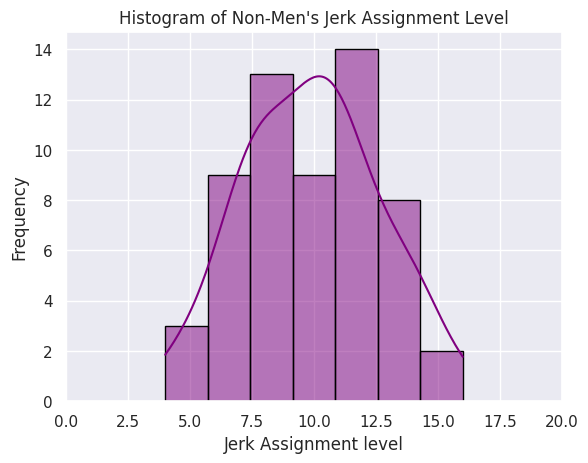

In [ ]:
# identifying which columns have a situation that impacts a woman
women_related = ['My girlfriend is a doctor. Lately she\'s been complaining about pain in her right knee and constantly taking TONS of ibuprofen to treat (like 15-20 pills a day). However, it\'s only gotten worse. I\'ve told her she needs to see someone about it but she told me it was fine. So I told her that if this is how she treats herself, I\'d be concerned about being her patient. She was shocked and told me that was uncalled for. Am I a jerk?',
                 'My daughter is getting married soon. I only learned about her a few years ago. We\'ve been building a relationship the last few years though and I am lucky to have her in my life now. Recently, she asked me to walk her down the aisle and while I am honored I told her no. Her step-dad practically raised her from a baby and I think that he deserves it far more than me. She was really upset and hurt when I said no. Am I a jerk?',
                 'I\'m a trust fund kid; I get a healthy \'allowance\' from my parents, but I mostly sock it away since I don\'t really feel like I deserve it. I live with my girlfriend, who comes from a poor family, and we split things 50-50. Recently, she found out how much money my parents send me each month and freaked out, saying it wasn\'t fair that I was making her split things 50/50. I told her it was my money, and it only seems fair if we cover half the expenses. Am I a jerk?',
                 'My wife and I have separate finances, but I pay for almost everything. My son starts school next year, and I\'m planning on sending him to a private school. My wife\'s son currently goes to a much less nice public school. My wife says I\'m a jerk for not paying for her daughter to go to private school as well.',
                 'My sister\'s nine year old daughter is poorly behaved. One day, my sister dropped the daughter off on my doorstep without my consent and drove off, texting me that she needed me to watch her daughter for the day. The daughter complained of being hungry, so I gave her the leftovers I had. She said she didn\'t like them, but I told her that\'s all there was. She put them in the microwave until they burned, then told me she couldn\'t eat them and we would have to go out and get food. I told her that was what there was to eat, and if she ruined it she\'d have to wait for her mom to get back. Later, everyone yelled at me for \'starving\' a child. Am I a jerk?',
                 'My parents want us to come out for their anniversary, and bought my sister and I tickets on the same flight. My sister has two kids - a 6 month old and a 5 year old. She is currently separated from her husband so she would have to handle 2 children by herself on a 10 hour flight.\n\nShe calls me up a week or so beforehand and asks me if I will be willing to help her take care of her kids on the flight, and something about taking shifts so we can both sleep. I tell her that I wasn\'t comfortable with that, but she says "nephew loves you so much" so we can work something out on the flight and hangs up.\n\nWhen I got to the airport, I chose to upgrade my seat so I could sit by myself and didn\'t mention it until we were on the plane. My family freaked and told me I abandoned my sister. Am I a jerk?',
                 'I have a child with a mother who never wanted anything to do with them. I make enough money to cover my expenses, but I constantly check up on the child\'s mother to make sure she\'s paying adequate child support. Periodically I either hire an investigator or her mom just tells me she got a raise and I go to court to adjust the child support accordingly. The last time I did this, she didn\'t show up for court and I apparently overestimated how much her raise was and I got a default judgment. She called me up and practically pleaded with me to lower her payments after I said no she insulted me and my son. Am I a jerk?',
                 'One of my children wants to go to an expensive school to become a dentist. I told them I\'d be fine paying for it. The other one wants to go to a similarly expensive school to become a teacher. I told her that I wouldn\'t pay for her schooling unless she picked a career path that will make at least 100,000 a year. Am I a jerk?',
                 'My wife has decided that since she can’t drink because she is pregnant that I can’t either. I planned to take my annual leave from work to take us (and pay for) a trip abroad. I asked my wife would the drinking rule still be in effect and she said of course. I’ve now decided I won’t be paying for us to take this trip. Am I a jerk?',
                 'My sister is going to be a bridesmaid at my wedding. Her hair was dyed, but she recently decided to grow it out, so parts of it are bleached and part are not. I told her it wouldn\'t look good in the pictures, and offered to pay for her to dye it. She said no, and I said she couldn\'t be in the wedding party. Am I a jerk?']

# creating columns to total up the number of each assessment
df['NotJerkCount'] = df[women_related].applymap(lambda x: x.count('Not a jerk')).sum(axis=1)
df['StrongJerkCount'] = df[women_related].applymap(lambda x: x.count('Strongly a jerk')).sum(axis=1)
df['MildJerkCount'] = df[women_related].applymap(lambda x: x.count('Mildly a jerk')).sum(axis=1)

# creating the contingency table
women_jerk = pd.DataFrame(0, index=["strongly a jerk", "mildly a jerk", "not a jerk"], columns=["man", "not a man"])
for index, row in df.iterrows():
    if row['What bests represents your gender?'] == "Male":
        women_jerk.loc['strongly a jerk', 'man'] += row['StrongJerkCount']
        women_jerk.loc['mildly a jerk', 'man'] += row['MildJerkCount']
        women_jerk.loc['not a jerk', 'man'] += row['NotJerkCount']
    else:
        women_jerk.loc['strongly a jerk', 'not a man'] += row['StrongJerkCount']
        women_jerk.loc['mildly a jerk', 'not a man'] += row['MildJerkCount']
        women_jerk.loc['not a jerk', 'not a man'] += row['NotJerkCount']

# running a chi squared test to see if there is a significant association between men and non-men when it comes the level to which you consider someone a jerk when they're interacting w a woman
# Null hypothesis: Being a man and the level to which you consider people jerks when they're interacting with women are independent variables
# Alternate hypothesis: There's a significant association between whether you're a man and the level to which you consider people jerks when they're interacting with women
chi2, p, dof, expected = sp.stats.chi2_contingency(women_jerk)
print("Contingency Table:", women_jerk)
# there is a significant association between whether youre a man and the level to which you consider someone a jerk when interacting w a woman
print("P-value:", p)

# running a 2 sample, 1 tailed t-test to see if men find the people more jerky or less jerky
# Null hypothesis: There is no difference, or the 'Female' distribution is greater.
# Alternate hypothesis: The 'Male' distribution is greater.
# 0 = not a jerk, 1 = mild jerk, 2 = strong jerk
import scipy.stats as stats
df['Jerkyness'] = df['MildJerkCount'] + df['StrongJerkCount']*2
male_data = df[df['What bests represents your gender?'] == 'Male']['Jerkyness']
nonmale_data = df[df['What bests represents your gender?'] != 'Male']['Jerkyness']
t_stat, p_value = stats.ttest_ind(male_data, nonmale_data, alternative='greater')
#
print("P-value of one-tailed t-test:", p_value)

# create a histogram
sns.set(style="darkgrid")
sns.histplot(male_data, bins=10, kde=True, alpha=0.5, color='teal', edgecolor='black')
plt.xlabel('Jerk Assignment level')
plt.ylabel('Frequency')
plt.title('Histogram of Men\'s Jerk Assignment Level')
plt.show()

sns.histplot(nonmale_data, bins=7, kde=True, alpha=0.5, color='purple', edgecolor='black')
plt.xlabel('Jerk Assignment level')
plt.ylabel('Frequency')
plt.title('Histogram of Non-Men\'s Jerk Assignment Level')
plt.xlim(0, 20)
plt.show()

# the non-male distribution is greater. Men are less likely to think these people are being jerks to women.
# we know the distributions are different from the chi-squared test
df = df.drop(['StrongJerkCount', 'MildJerkCount', 'NotJerkCount'], axis=1)

## **Question 3: Does being male or female cause a statistically significant difference in whether an individual holds different political stances than their parents? (not counting change in strength as a change)**

In [ ]:
# Does being male or female cause a statistically significant difference in whether an
# individual holds a different political stances than their parents? (not counting changes in strength as changes)

# new columns without the strengths considered
df['ParentMod'] = df['You could describe the adults you grew up with as...'].str.replace(r'Strongly |Mildly ', '', regex=True)
df['YoursMod'] = df['You could describe yourself as...'].str.replace(r'Strongly |Mildly ', '', regex=True)
df['Changed'] = df['ParentMod'] != df['YoursMod']

#removing non-binary people since there aren't enough people to form a good sample
df = df[df['What bests represents your gender?'] != 'Non-binary / other']

# making the contingency table (true if view was changed)
gender_change = pd.crosstab(df['What bests represents your gender?'], df['Changed'])

# running a chi squared test to see if there is a significant association between whether youre a man or woman and whether you changed political stances
# Null hypothesis: Being a man or woman and whether you changed political views are independent variables
# Alternate hypothesis: There's a significant association between being a man or woman and whether you changed political views
chi2, p, dof, expected = sp.stats.chi2_contingency(gender_change)
print("Contingency Table:", gender_change)
# there is no significant association between whether youre a male/female and whether you change political views
print("P-value:", p)

Contingency Table: Changed                             False  True 
What bests represents your gender?              
Female                                 21     31
Male                                   74     81
P-value: 0.44695543904457313
